In [ ]:
%%time
%%capture
! sudo apt-get install texlive-latex-recommended 
! sudo apt-get install dvipng texlive-latex-extra texlive-fonts-recommended  
! wget http://mirrors.ctan.org/macros/latex/contrib/type1cm.zip 
! unzip type1cm.zip -d /tmp/type1cm 
! cd /tmp/type1cm/type1cm/ && sudo latex type1cm.ins
! sudo mkdir /usr/share/texmf/tex/latex/type1cm 
! sudo cp /tmp/type1cm/type1cm/type1cm.sty /usr/share/texmf/tex/latex/type1cm 
! sudo texhash 
! apt install cm-super

CPU times: user 526 ms, sys: 108 ms, total: 634 ms
Wall time: 1min 7s



#Importe e instalación de librerías.

Para el desarrollo y seguimiento de este material, resulta importante comenzar por instalar e importar elementos que nos serán suma utilidad, entre ellas tenemos pylab y la librería Python tight binding (Pythtb).

In [ ]:
%%capture
!pip install pythtb --upgrade

In [ ]:
from pylab import *
from multiprocessing import Pool

In [ ]:
from pythtb import *

In [ ]:
mpl.rcParams.update({'font.size': 18, 'text.usetex': True})
mpl.rcParams.update({'axes.linewidth':1.5})
mpl.rcParams.update({'axes.labelsize':'large'})
mpl.rcParams.update({'xtick.major.size':6})
mpl.rcParams.update({'xtick.minor.size':4})
mpl.rcParams.update({'ytick.major.size':6})
mpl.rcParams.update({'ytick.minor.size':4})
mpl.rcParams.update({'xtick.major.width':1.5})
mpl.rcParams.update({'xtick.minor.width':1.0})
mpl.rcParams.update({'ytick.major.width':1.5})
mpl.rcParams.update({'ytick.minor.width':1.0})
mpl.rcParams.update({'legend.frameon':False,'legend.framealpha':0.0})

In [ ]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
from IPython.display import Image


#Usando python tight binding (PYTHTB).

Una libreria que nos resulta de especial utilidad es *python tight binding*, en la que podemos definir los parámetros de nuestra red para posteriormente resolver el hamiltoniano en una aproximación de amarre fuerte. Dado lo anterior, es menester definir los parámetros que se modulan o toman en cuenta en el hamiltoniano de la celda unitaria. 

Definir dichos parámetros resulta esencial debido a que son aquellos que están directamente relacionados con el fenómeno de bombeo, que entendemos como un transporte de carga en la estructura de mi material entre dos puntos distintos. 

Así, tenemos nuestra red...



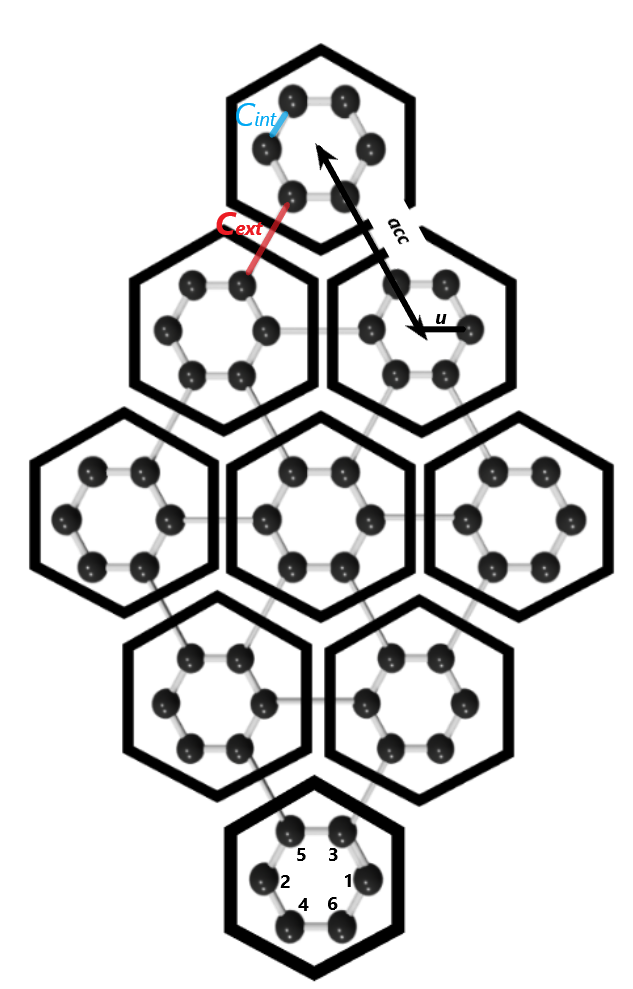

In [ ]:
Image(filename = "red_param.png", width = 600)

El Hamiltoniano de la celda unitaria es:
    
\begin{align}
H = \left[ \begin{array}{cccccc}
\delta E(\theta)      & c_{\rm ext}(\theta) e^{-i\vec{k}\cdot a_1} 
& c_{\rm int}(\theta) & 0                    
& 0                   & c_{\rm int} (\theta) \\
c_{\rm ext}(\theta) e^{i\vec{k}\cdot a_1} & -\delta E(\theta)                          & 0                   & c_{\rm int}(\theta)  & c_{\rm int}(\theta) & 0 \\
c_{\rm int}(\theta)                        & 0                                          & -\delta E(\theta)   & c_{\rm ext}( \theta)e^{-i\vec{k}\cdot a_2} & c_{\rm int}(\theta) & 0 \\
0 & c_{\rm int}(\theta)                    & c_{\rm ext} ( \theta)e^{i\vec{k}\cdot a_2} & \delta E (\theta)   & 0                    & c_{\rm int}(\theta) \\
0 & c_{\rm int}(\theta)                    & c_{\rm int}(\theta)                        & 0                   & \delta E (\theta)    & c_{\rm ext} (\theta)e^{-i\vec{k}\cdot a_3} \\
c_{\rm int} (\theta)                       & 0                                          & 0                   & c_{\rm int} (\theta) & c_{\rm ext} (\theta)e^{i\vec{k}\cdot a_3} & -\delta E (\theta) 
\end{array}\right]
\end{align}

donde 

\begin{align}
c_{\rm int}(\theta) &=  t e^{-\beta (acc(1-u cos(\theta)) / acc-1) } \\
c_{\rm ext}(\theta) &=  t e^{-\beta \big[ acc-2 u(\theta) \big] } \\
\delta E (\theta) &= \epsilon \sin (\theta)\\
\end{align}

Considerando este hamiltoniano, establecemos los parametros requeridos para nuestro modelo en *pythtb*.

In [ ]:
π = pi
t = -2.7 # eV parámetro de acoplamiento
β = 3.37 # parámetro de gruneissen 
ϵ = 0.05 # 50 meV energía en el sitio
u = 0.2  # la deformación máxima es del 20%
acc = 1.42 # distancia carbono carbono

def func_cext(θ):
    return t*exp(-β*( acc*(1+u*cos(θ))/acc - 1 ))

def func_cint(θ):
    return t*exp(-β*( acc*(1-u*cos(θ))/acc - 1 ))

def func_δE(θ):
    return ϵ*sin(θ)

γ = 1.0 # 0.1*(1J)

Lo siguiente es armar nuestro modelo de amarre fuerte, en el que incluimos los vectores de red (*lat*), los sitios de red y por último los hoppings, es importante mencionar que el hopping establecido para cada par de átomos será único, es decir,al definir el hopping del sitio 1 al 2, automáticamente quedará definido el hopping 2-1.

In [ ]:
def hexaModel(θ):
    a2 = array([ 1/2,sqrt(3)/2]) #vectores de red
    a3 = array([-1/2,sqrt(3)/2])
    a1 = a2-a3

    A1 = 2*a2
    A2 = 2*a3
    lat = [ A1, A2]
    orb = [ array([1,-1])/3, array([-1,1])/3, 
            array([1,0])/3, array([-1,0])/3, 
            array([0,1])/3, array([0,-1])/3  ] #sitios, 1/3a, coordenadas
    hexa = tb_model(2, 2, lat, orb) #dimreal,dimrecíproco,vectores de red, orbitales o sitios en term 
                                    #de los vectores de red
    
    ϵ1 = 1e-3
    ϵ2 = 1e-4
    hexa.set_onsite([γ*func_δE(θ)   ,-γ*func_δE(θ),        #términos en la diagonal del hamiltoniano
                    -γ*func_δE(θ)-ϵ1, γ*func_δE(θ)+ϵ1,
                     γ*func_δE(θ)+ϵ2,-γ*func_δE(θ)-ϵ2])
    #funcion que asigna un valor del hopping, valor del hopping entre que sitios (etiquetas) 
    #de que sitio a qué sitio va, al final el término exponencial
    hexa.set_hop(func_cint(θ), 0, 2, [ 0, 0])
    hexa.set_hop(func_cint(θ), 1, 3, [ 0, 0])
    hexa.set_hop(func_cint(θ), 2, 4, [ 0, 0])
    hexa.set_hop(func_cint(θ), 3, 5, [ 0, 0])
    hexa.set_hop(func_cint(θ), 4, 1, [ 0, 0])
    hexa.set_hop(func_cint(θ), 5, 0, [ 0, 0])
    
    hexa.set_hop(func_cext(θ), 0, 1, [ 1,-1])
    hexa.set_hop(func_cext(θ), 2, 3, [ 1, 0])
    hexa.set_hop(func_cext(θ), 4, 5, [ 0, 1])
    
    return hexa


# Bandas del Hamiltoniano de Bloch.

Para visualizar la estructura de bandas en el espacio recíproco, seleccionamos el modelo definido anteriormente para un valor definido de $\theta$ , para el que resolvemos el hamiltoniano y obtenemos los 
eigenvalores para el camino de puntos k dados en *path*, que corresponde a los puntos de alta simetría y graficamos.

---------------------------------------
starting calculation
---------------------------------------
Calculating bands...
(6, 101)


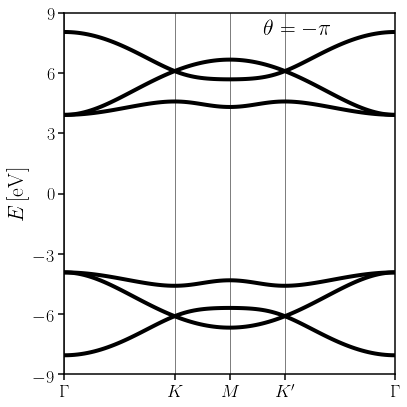

In [ ]:
hexa=hexaModel(-pi)
etiqueta = r"$\theta=-\pi$"
# Lista de puntos en el espacio recíproco 
# en términos de los vectores de la red recíproca

path  = [      [0,0],[2/3,1/3],[0.5,0.5],[1/3,2/3],      [0,0]]
label = [r"$\Gamma$",   r"$K$",   r"$M$",  r"$K'$",r"$\Gamma$"]

# La función k_path regresa el camino de los puntos k
# en el espacio recíproco que pasan por los puntos 
# dados en el argumento path
k_vec, k_dist, k_node = hexa.k_path(path,101,report=False) #Si quiero poner el report debo quitar el report false
# k_vec : arreglo con las parejas (kx,ky)
# k_dist: arreglo con las distancia de separación entre puntos k
# k_node: arreglo con la distancia de cada punto del path

print('---------------------------------------')
print('starting calculation')
print('---------------------------------------')
print('Calculating bands...')

# Obtiene los eigenvalores para cada punto (kx,ky) de k_vec
evals = hexa.solve_all(k_vec)

# La función shape regresa la forma del arreglo 
# que reciba como argumento
print(shape(evals))
# En este caso dice que son seis eigenvalores por cada punto k
# Figura con la estructura de bandas

# Establecemos el nombre de la figura (fig)
# y los ejes dónde graficaremos (ax)
fig, ax = plt.subplots(ncols=1,nrows=1,figsize=(6,6))

# Graficamos las 6 bandas
for n in range(6):
    ax.plot(k_dist,evals[n],color='k',lw=4)

# Colocamos los xticks en los puntos del path
ax.set_xticks(k_node)
# Colocamos las etiquetas de los xticks 
ax.set_xticklabels(label)

# Dibujamos líneas verticales en cada xtick
for n in range(len(k_node)):
  ax.axvline(x=k_node[n], lw=0.5, color='k')

# Colocamos un título a la gráfica
# ax.set_title("Modelo hexa")
# Colocamos una etiqueta al eje x
# ax.set_xlabel("Camino en el espacio k")
# Colocamos una etiqueta al eje y
ax.set_ylabel(r"$E\,[{\rm eV}]$")

ax.text(0.6,8.0,etiqueta,fontsize=22)
# Especificamos los límites de graficación en el 
# eje de las abcisas
ax.set_xlim(k_node[0],k_node[-1]) #de 0 a -1
ax.set_ylim(-9,9)
ax.set_yticks([-9,-6,-3,0,3,6,9])
# Ajustamos los ejes y etiquetas antes de guardar la figura
fig.tight_layout()
# Guardamos la figura como un pdf
fig.savefig("BandasHexamodel_pi.png",dpi=300)

---------------------------------------
starting calculation
---------------------------------------
Calculating bands...
(6, 101)


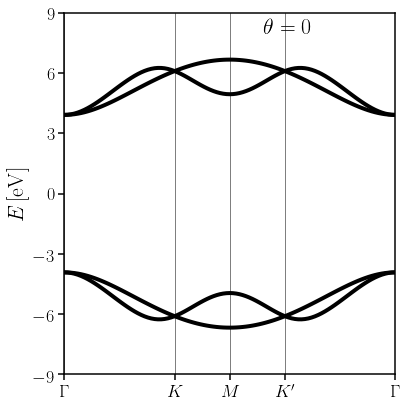

In [ ]:
hexa=hexaModel(0)
etiqueta = r"$\theta=0$"
# Lista de puntos en el espacio recíproco 
# en términos de los vectores de la red recíproca

path  = [      [0,0],[2/3,1/3],[0.5,0.5],[1/3,2/3],      [0,0]]
label = [r"$\Gamma$",   r"$K$",   r"$M$",  r"$K'$",r"$\Gamma$"]

# La función k_path regresa el camino de los puntos k
# en el espacio recíproco que pasan por los puntos 
# dados en el argumento path
k_vec, k_dist, k_node = hexa.k_path(path,101,report=False) #Si quiero poner el report debo quitar el report false
# k_vec : arreglo con las parejas (kx,ky)
# k_dist: arreglo con las distancia de separación entre puntos k
# k_node: arreglo con la distancia de cada punto del path

print('---------------------------------------')
print('starting calculation')
print('---------------------------------------')
print('Calculating bands...')

# Obtiene los eigenvalores para cada punto (kx,ky) de k_vec
evals = hexa.solve_all(k_vec)

# La función shape regresa la forma del arreglo 
# que reciba como argumento
print(shape(evals))
# En este caso dice que son seis eigenvalores por cada punto k
# Figura con la estructura de bandas

# Establecemos el nombre de la figura (fig)
# y los ejes dónde graficaremos (ax)
fig, ax = plt.subplots(ncols=1,nrows=1,figsize=(6,6))

# Graficamos las 6 bandas
for n in range(6):
    ax.plot(k_dist,evals[n],color='k',lw=4)

# Colocamos los xticks en los puntos del path
ax.set_xticks(k_node)
# Colocamos las etiquetas de los xticks 
ax.set_xticklabels(label)

# Dibujamos líneas verticales en cada xtick
for n in range(len(k_node)):
  ax.axvline(x=k_node[n], lw=0.5, color='k')

# Colocamos un título a la gráfica
# ax.set_title("Modelo hexa")
# Colocamos una etiqueta al eje x
# ax.set_xlabel("Camino en el espacio k")
# Colocamos una etiqueta al eje y
ax.set_ylabel(r"$E\,[{\rm eV}]$")

ax.text(0.6,8.0,etiqueta,fontsize=22)
# Especificamos los límites de graficación en el 
# eje de las abcisas
ax.set_xlim(k_node[0],k_node[-1]) #de 0 a -1
ax.set_ylim(-9,9)
ax.set_yticks([-9,-6,-3,0,3,6,9])
# Ajustamos los ejes y etiquetas antes de guardar la figura
fig.tight_layout()
# Guardamos la figura como un pdf
fig.savefig("BandasHexamodel_0.png",dpi=300)

Podemos observar que en ambos casos tenemos el hamiltoniano correspondiente a un aislante, ya que no hay estados que crucen la banda prohibida.


#Bombeo de estados en una nanohojuela de grafeno.

Comenzaremos por definir la estructura y parámetros de nuestro sistema de estudio.

Primero, delimitamos el tamaño de sistema, es decir, partiendo de una red infinita de grafeno, realizamos dos cortes para tener finalmente una estructura de nanohojuela de 3x3 celdas unitarias repetidas.

Para visualizarlo de mejor manera, primero esquematizaremos la celda unitaria y las direcciones del alargamiento de red. 

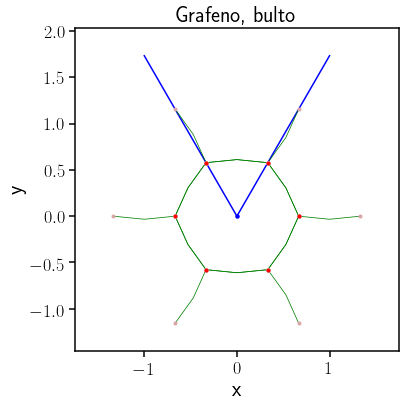

In [ ]:
hexa     = hexaModel(π/3)
(fig,ax) = hexa.visualize(0,1)
ax.set_title("Grafeno, bulto")
ax.set_xlabel("x")
ax.set_ylabel("y")
fig.tight_layout()

Como siguiente paso. *definimos* los cortes a realizar sobre la red de grafeno, y visualizamos. La repetición será de 3x3 celdas unitarias, definidas por la variable *L*.

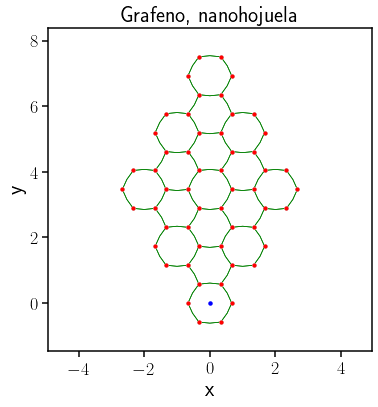

In [ ]:
# Repetición de la celda unitaria
L=3
hexa    = hexaModel(4*pi/3)
cut_one = hexa.cut_piece(L,0,glue_edgs=False)
cut_two = cut_one.cut_piece(L,1,glue_edgs=False)
# Visualización
(fig,ax)=cut_two.visualize(0,1)
ax.set_title("Grafeno, nanohojuela")
ax.set_xlabel("x")
ax.set_ylabel("y")
fig.tight_layout()
fig.savefig("lat2x2.png",dpi=300)

Ya que contamos con nuestra red finita, el siguiente paso consiste en calcular sus eigenvalores y graficar el espectro energético. Observamos que la metodología para seleccionar la red es la misma y añadimos la función *solve* que nos regresa los eigenvalores y eigenvectores de nuestro hamiltoniano en la red finita y los valores dados de θ. 

In [ ]:
# Obtener eigenvalores del la red finita
# para todos los valores de θ
def ModeloHOTI(θ):
    L=3
    hexa    = hexaModel(θ)
    cut_one = hexa.cut_piece(L,0,glue_edgs=False)
    cut_two = cut_one.cut_piece(L,1,glue_edgs=False)
    E,U    = cut_two.solve_all(eig_vectors=True)
    return E,U

θ    = linspace(-π,π,1000)  # Intervalo de θ
DATA = list( map(ModeloHOTI,θ)) 

Datosθ = {}
for n in range(len(θ)):
  Datosθ[θ[n]] = {"E":DATA[n][0], "U":DATA[n][1]}

Para poder localizar los valores de energía correspondientes a nuestros bordes (que son nuestros puntos d einterés al querer describir el bombeo), debemos identificar el índice al que corresponden dichos sitios y así extraer y colorear específicamente el valor de energía que les corresponde. Enumeramos cada uno de los sitios y graficamos.

(-1.0, 15.0)

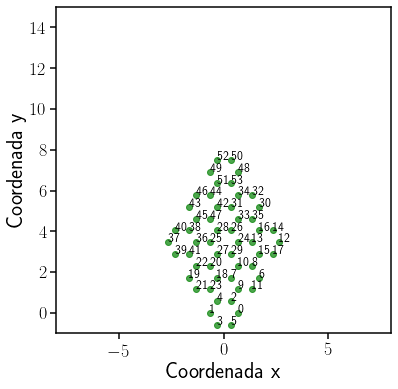

In [ ]:
# Obtenemos las coordenadas del la red "cut_two"
A1,A2 = cut_two.get_lat()

X,Y = [],[]
for n in range(len(cut_two.get_orb())):
    x,y = dot(cut_two.get_orb()[n], (A1,A2))
    X.append(x)
    Y.append(y)
X = array(X)
Y = array(Y)

# Graficar para ver quienes son los puntos de la red
fig, ax = plt.subplots(figsize=(6,6) )
ax.scatter(X,Y,c="green",alpha=0.7)
for n in range(len(X)):
    ax.text(X[n],Y[n],"{0}".format(n),fontsize=12)
ax.set_xlabel("Coordenada x")
ax.set_ylabel("Coordenada y")
ax.set_xlim(-8,8)
ax.set_ylim(-1,15)

Ahora que identificamos los sitios que corresponden a las esquinas con las etiquetas [39,40] y [17,14] para las esquinas izquierda y derecha correspondientemente, procedemos a graficar el espectro energético.

In [ ]:
# Donde estan las esquinas
# Izquierda : indice 39 y 40
# Derecha   : indice 14 y 17
indIzq = [39,40] #3x3
indDer = [14,17]

# Datos[n] = {"θ":θ[n], "E":DATA[n][0], "U":DATA[n][1]}
for θn in θ:
  ListaProbIzq  = [] #Listas donde almacenaremos los datos de probabilidad de
  ListaProbDer  = [] #encontrar los estados en cada sitio.
  ListaProbBulk = []
  for en in range(54):
    ProbIzq = real(Datosθ[θn]["U"][en][39]*conjugate(Datosθ[θn]["U"][en][39]) \
             +Datosθ[θn]["U"][en][40]*conjugate(Datosθ[θn]["U"][en][40]))
    ProbDer = real(Datosθ[θn]["U"][en][14]*conjugate(Datosθ[θn]["U"][en][14]) \
             +Datosθ[θn]["U"][en][17]*conjugate(Datosθ[θn]["U"][en][17]))
    ProbBulk= 1 - ProbIzq - ProbDer
    ListaProbIzq.append( ProbIzq)
    ListaProbDer.append( ProbDer )
    ListaProbBulk.append(ProbBulk)
  Datosθ[θn]["ProbIzq"]  = array( ListaProbIzq )
  Datosθ[θn]["ProbDer"]  = array( ListaProbDer )
  Datosθ[θn]["ProbBulk"] = array( ListaProbBulk) 

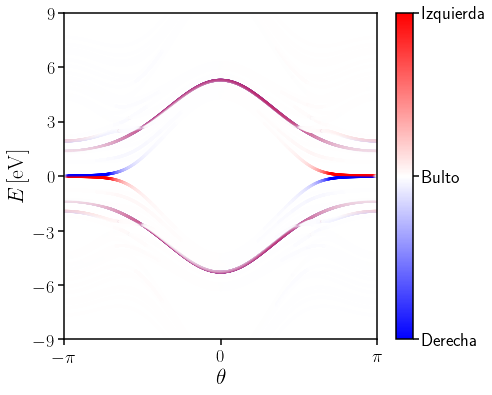

In [ ]:
fig,ax = plt.subplots(ncols=1,nrows=1,figsize=(7,6)) #Espectro de sección transversal Tight-binding
#for n in range(len(Ek)): 
    #ax.scatter(θ,Ek[n].real,c='b',s=3)   

for θn in θ:
  E = Datosθ[θn]["E"]
  xval = θn*ones(len(E))
  Prob = Datosθ[θn]["ProbIzq"]-Datosθ[θn]["ProbDer"]
  graf = ax.scatter( xval,E,c=Prob,s=3,cmap='bwr',vmax=0.2,vmin=-0.2 )
barracolor = fig.colorbar(graf,pad=0.05,ticks=[-0.2,0,0.2])
barracolor.ax.set_yticklabels(['Derecha', 'Bulto', 'Izquierda'])  # vertically oriented colorbar
#c ="b"
#c="#EEEEEE"
#c = entre cero y uno

ax.set_xlim(-π,π)
ax.set_ylim(-9,9)
#ax.set_yticks([-10,-5,0,5,10] )
ax.set_yticks([-9,-6,-3,0,3,6,9] )
ax.set_xticks([-pi,0,pi])
ax.set_xticklabels([r'$-\pi$',r'$0$',r'$\pi$'])
ax.set_xlabel(r"$\theta$")
ax.set_ylabel(r"$E\,[{\rm eV}]$")

fig.savefig("UNO6x6.png",dpi=300)

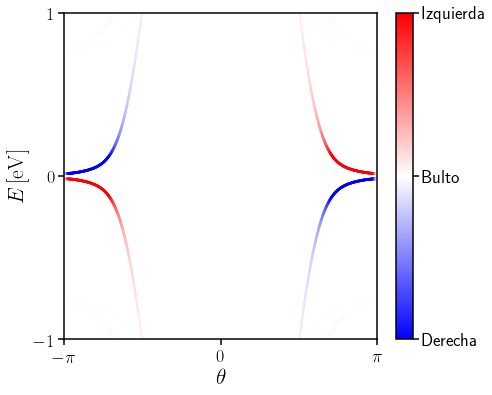

In [ ]:
fig,ax = plt.subplots(ncols=1,nrows=1,figsize=(7,6)) #Espectro de sección transversal Tight-binding
#for n in range(len(Ek)): 
    #ax.scatter(θ,Ek[n].real,c='b',s=3)   

for θn in θ:
  E = Datosθ[θn]["E"]
  xval = θn*ones(len(E))
  Prob = Datosθ[θn]["ProbIzq"]-Datosθ[θn]["ProbDer"]
  graf = ax.scatter( xval,E,c=Prob,s=3,cmap='bwr',vmax=0.2,vmin=-0.2 )
barracolor = fig.colorbar(graf,pad=0.05,ticks=[-0.2,0,0.2])
barracolor.ax.set_yticklabels(['Derecha', 'Bulto', 'Izquierda'])  # vertically oriented colorbar
#c ="b"
#c="#EEEEEE"
#c = entre cero y uno

ax.set_xlim(-π,π)
ax.set_ylim(-1,1)
#ax.set_yticks([-10,-5,0,5,10] )
ax.set_yticks([-1,0,1] )
ax.set_xticks([-pi,0,pi])
ax.set_xticklabels([r'$-\pi$',r'$0$',r'$\pi$'])
ax.set_xlabel(r"$\theta$")
ax.set_ylabel(r"$E\,[{\rm eV}]$")

fig.savefig("DOS6x6.png",dpi=300)

El resultado nos muestra que al inicio del ciclo de bombeo, los estados están localizados en la esquina izquierda (derecha) y al transcurrir el tiempo, estos se distribuyen a lo largo del bulto, mientras que finalizar el ciclo, los estados se encuentran nuevamente localizados pero ahora en la esquina derecha (izquierda).